In [1]:
import os 
import gc
import sys
import random
import numpy as np
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_mutual_info_score as AMI
from MulticoreTSNE import MulticoreTSNE as TSNE

In [2]:
# supress future warning
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [3]:
%reload_ext autoreload
%autoreload 2
#sys.path.insert(1, os.path.join(sys.path[0],"/src_analysis/lib_hdfs" ) )
from analysis_lib import get_rand_colors

In [4]:
def compute_aggl(data, clusters, verbose=False):
    """
    IN:
        data; np.array[#data, #dim]
    """
    method = AgglomerativeClustering(n_clusters=clusters)
    patches_labels = method.fit_predict(data)
    if verbose:
        print("### NCluster = %d | NData = %d ###" % (
                clusters , data.shape[0]
            )
         )
    return patches_labels

def gen_data(x,y):
    n = len(x)
    ret = np.concatenate([x.reshape(n,1), y.reshape(n,1)], axis=1)
    return ret 

def gen_multi_data(X):
    '''
    Same as gen_data, except for multidimensional data
    New args
        X: Array of inputs, size of (n_features, n_samples)
    '''
    dim = X.shape[0]
    n = X.shape[1]
    ret = X[0].reshape(n,1) 
    for d in range(1,dim): 
        ret = np.concatenate([ret, X[d].reshape(n,1)], axis=1)
    return ret
   
def gen_rdata(x,y,scale):
    data = gen_data(x,y)
    npoints = np.array([i for i in range(len(data))])
    
    _seed = random.randint(0,99999)
    random.seed(_seed)
    random.shuffle(npoints)
    try:
        if not len(data) <= scale:
            return data[npoints[:scale]], npoints[:scale]
    except:
        raise ValueError("scale arg is larger than original data")
        
def gen_multi_rdata(X,scale,transp=True):
    '''
    Same as gen_rdata, except for multidimensional data
    New args 
        X: Array of inputs
        transp: whether or not to call gen_multi_data on X
    ''' 
    if transp:
        data = gen_multi_data(X)
    else: 
        data = X
    npoints = np.array([i for i in range(len(data))])
    
    _seed = random.randint(0,99999)
    random.seed(_seed)
    random.shuffle(npoints)
    try:
        if not len(data) <= scale:
            return data[npoints[:scale]], npoints[:scale]
    except:
        raise ValueError("scale arg is larger than original data")

In [5]:
### Cluster
cluster_list = [i for i in range(2,10,1)] + [ i for i in range(10,100,2)]

In [6]:
### Scale list
N = 10000
scale_list = [int(N/i) for i in [100,50,20,10,2]]

In [9]:
scale_list

[100, 200, 500, 1000, 5000]

In [7]:
figdir='/home/sydneyjenkins/scratch-midway2/anl/figs/amis'

In [8]:
def save_clusterfig(data,
                    labels,
                    *args,
                    figdir='./fig', 
                    n_cluster=-1, 
                    dist_type='normal',
                    data_type='truth'
                    ):
    """
    args: igroup, scale, 
    """
    if data_type is "truth":
        os.makedirs(os.path.join(figdir, dist_type+'/truth'), exist_ok=True)
        save_basepath = os.path.join(figdir, dist_type+'/truth')
    elif data_type is "holdout":
        os.makedirs(os.path.join(
            figdir, dist_type+'/holdout/group'+str(igroup)+'/scale'+str(iscale)),
            exist_ok=True
        )
        save_basepath = os.path.join(figdir, dist_type+'/holdout/group'+str(igroup)+'/scale'+str(iscale) )
    
    # get colors
    colors = get_rand_colors(n_cluster, cmap_name='rainbow', _seed=83459)
    
    if data_type is "truth":
        ###  plt all figure
        # + legend
        plt.figure()
        for icluster in range(n_cluster):
            idx = np.where(labels == icluster)  # assume 1D array, idx[# of points].
            plt.scatter(data[idx, 0], data[idx, 1], color=colors[icluster], label="{}".format(icluster), s=2)
        plt.savefig(save_basepath+'/dist_alls_nc-'+str(n_cluster)+'_legend.png', dpi=200)
        plt.close()
    
        # save color legend
        plt.figure()
        ncol=1
        if ncol>9:
            ncol=2
        for i in range(len(colors)):
            plt.scatter(1,i,color=colors[i], label='{}'.format(i))
        plt.legend(ncol=ncol)
        plt.savefig(save_basepath+'/legend_nc-'+str(n_cluster)+'.png', dpi=200)
        plt.close()
    
        # + text
        plt.figure()
        for icluster in range(n_cluster):
            idx = np.where(labels == icluster)  # assume 1D array, idx[# of points].
            plt.scatter(data[idx, 0], data[idx, 1], color=colors[icluster], label="{}".format(icluster), s=2)
            xtext, ytext = np.mean(data[idx, :], axis=0)[0]  #debug (1,2)--> d[0] = (2,)
            txt = plt.text(xtext, ytext, str(icluster), fontsize=10)   
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground="w"),
                PathEffects.Normal()])
        plt.savefig(save_basepath+'/dist_alls_text_nc-'+str(n_cluster)+'.png', dpi=200)
        plt.close()
    
        # individual
        os.makedirs(save_basepath+'/clusters', exist_ok=True)
        for icluster in range(n_cluster):
            fig = plt.figure()
            plt.scatter(data[:, 0], data[:, 1], color='gray', alpha=0.8)
            idx = np.where(labels == icluster)  # assume 1D array, idx[# of points].
            plt.scatter(data[idx, 0], data[idx, 1], color=colors[icluster])
            plt.savefig(save_basepath+'/clusters/dist_nc-'+str(n_cluster)+'_ic-'+str(icluster)+'.png', dpi=200)
            plt.close()
    
    elif data_type is "holdout":
        ###  plt all figure
        # + legend
        plt.figure()
        plt.scatter(data[:, 0], data[:, 1], color='gray', alpha=0.3, s=2)
        plt.scatter(test_data[:, 0], test_data[:, 1], color='black', alpha=0.7,s=2)
        for icluster in range(n_cluster):
            idx = np.where(labels == icluster)  # assume 1D array, idx[# of points].
            plt.scatter(test_data[idx, 0], test_data[idx, 1], color=colors[icluster], label="{}".format(icluster), s=2)
        plt.savefig(save_basepath+'/dist_alls_nc-'+str(n_cluster)+'_is-'+str(iscale)+'_legend.png', dpi=200)
        plt.close()
    
        # save color legend
        plt.figure()
        ncol=1
        if ncol>9:
            ncol=2
        for i in range(len(colors)):
            plt.scatter(1,i,color=colors[i], label='{}'.format(i))
        plt.legend(ncol=ncol)
        plt.savefig(save_basepath+'/legend_nc-'+str(n_cluster)+'.png', dpi=200)
        plt.close()
    
        # + text
        plt.figure()
        plt.scatter(data[:, 0], data[:, 1], color='gray', alpha=0.3, s=2)
        plt.scatter(test_data[:, 0], test_data[:, 1], color='black', alpha=0.7, s=2)
        for icluster in range(n_cluster):
            idx = np.where(labels == icluster)  # assume 1D array, idx[# of points].
            plt.scatter(test_data[idx, 0], test_data[idx, 1], color=colors[icluster], label="{}".format(icluster), s=2)
            xtext, ytext = np.mean(test_data[idx, :], axis=0)[0]  #debug (1,2)--> d[0] = (2,)
            txt = plt.text(xtext, ytext, str(icluster), fontsize=10)   
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground="w"),
                PathEffects.Normal()])
        plt.savefig(save_basepath+'/dist_alls_text_nc-'+str(n_cluster)+'_is-'+str(iscale)+'.png', dpi=200)
        plt.close()
    
        # individual
        os.makedirs(save_basepath+'/clusters', exist_ok=True)
        for icluster in range(n_cluster):
            fig = plt.figure()
            plt.scatter(data[:, 0], data[:, 1], color='gray', alpha=0.3, s=2)
            plt.scatter(test_data[:, 0], test_data[:, 1], color='black', alpha=0.7, s=2)
            idx = np.where(labels == icluster)  # assume 1D array, idx[# of points].
            plt.scatter(test_data[idx, 0], test_data[idx, 1], color=colors[icluster], s=2)
            plt.savefig(save_basepath+'/clusters/dist_nc-'+str(n_cluster)+'_is-'+str(iscale)+'_ic-'+str(icluster)+'.png', dpi=200)
            plt.close()
    

In [9]:
#TSNE functions
def get_rand_colors(n=10, cmap_name='jet', _seed = 12356):
    #colormap
    cmap = plt.cm.get_cmap(cmap_name, n)
    colors = []
    for idx, i in enumerate(range(cmap.N)):
        rgb = cmap(i)[:3]
        colors += [matplotlib.colors.rgb2hex(rgb)]
    # shuffle
    random.seed(_seed)
    random.shuffle(colors)
    return colors

def plot_tsne_individual(features_2d, labels, colors, n_cluster, scale, group, ncol=3):
    for i in range(n_cluster):
        os.makedirs('tsne/20c_fig/'+str(scale)+'k_group'+str(group), exist_ok=True)
        fig = plt.figure()
        idx = np.where(labels == i)
        jdx = np.where(labels != i)
        plt.scatter(features_2d[jdx,0], features_2d[jdx,1], 
                c='lightgrey',  s=0.5)  #,marker='.' )
        plt.scatter(features_2d[idx,0], features_2d[idx,1], 
                c= colors[i], label='c-'+str(i), s=10)  #,marker='.' )
        plt.title("tSNE nc-%d p-%d k" % (n_cluster, scale))
        plt.xlabel('tsne-1')
        plt.ylabel('tsne-2')
        plt.legend()  
        #plt.savefig('tsne/20c_fig/'+str(scale)+'k_group'+str(group)+'/tsne_cluster-'+str(i)+'nc-'+str(n_cluster)+'_p-'+str(scale)+'.png')
        
def compute_parallel_tsne(data, ndim=2, nproc=2, nperplex=15):
    tsne = TSNE(n_components=ndim, n_jobs=nproc, perplexity=nperplex)
    features = tsne.fit_transform(data)
    return features

In [10]:
mapping_list = [i for i in range(0,10,1)] + [i for i in range(10,22,2)]

In [13]:
mapping_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20]

### 1. Normal distribution

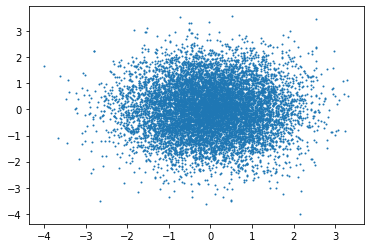

In [45]:
x = np.random.randn(10000)
y = np.random.randn(10000)
plt.scatter(x,y, s=1)

In [62]:
#Multidimensional data
dimensions = 128
X = []
for i in range(dimensions):
    current_vector = np.random.randn(N)
    X.append(current_vector) 
X = np.asarray(X)

In [72]:
### Cluster
cluster_list = [i for i in range(1,10,1)] + [ i for i in range(10,100,2)]

### AMI exp
ngroup = 5

# set array
true_labels = []
ami_scores = np.zeros((len(scale_list),ngroup,len(cluster_list)))
# psuedo grand truth
true_labels = [
    #compute_aggl(gen_data(x,y), i) for i in cluster_list
    compute_aggl(gen_multi_data(X), i) for i in cluster_list
]


# validaton data
for igroup in range(ngroup):
    print()
    print(" Entering Group %d " % igroup)
    for idx, iscale in enumerate(scale_list):
        #test_data, locs = gen_rdata(x,y,iscale)
        test_data, locs = gen_multi_rdata(X,iscale)
        for jdx, icluster in enumerate(cluster_list):
            labels = true_labels[jdx]
            test_labels = compute_aggl(test_data, icluster)
            ami_scores[idx, igroup, jdx] = AMI(labels[locs], test_labels)
            
            
        print("Normal End | Scale == %d " % iscale)
        gc.collect()

n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(1000

n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n featur

n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
Normal End | Scale == 500 
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n sam

n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n 

n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
Normal End | Scale == 200 
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n feature

n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n 

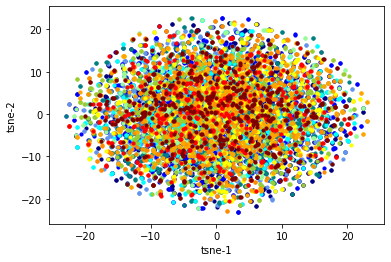

In [74]:
patches_ = gen_multi_data(X)
labels = true_labels[10]
colors =['navy','cornflowerblue','blue','teal',
         'aqua','palegreen', 'yellowgreen', 'darkorange',
         'yellow','orange','red','maroon'] #get_rand_colors(20)
features_2d = compute_parallel_tsne(patches_, ndim=2, nproc=4, nperplex=15)
#plot_tsne_individual(features_2d, labels, colors, n_cluster=12, scale=20, group=0, ncol=4 )

fig = plt.figure()
for i in range(12):
    idx = np.where(labels == i)
    plt.scatter(features_2d[idx,0], features_2d[idx,1], s=10, color=colors[i])
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')
plt.show()
#plt.savefig('tsne/12c_fig/all_clusters_15perplex_colors.png')
plt.close()

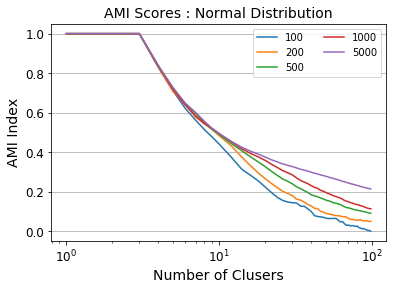

In [75]:
fig = plt.figure()
for idx, iscale in enumerate(scale_list):
    plt.plot([i for i in cluster_list], 
            mean_amis_scores[idx],
             label=str(iscale)
            )

plt.yticks(np.linspace(0,1,6), fontsize=12)
#plt.xticks( [i for i in range(1,len(cluster_list),1)], 
#            [ str(i) for i in cluster_list], fontsize=12)
plt.xticks(fontsize=12)
plt.xscale('log')
plt.gca().yaxis.grid(True, which='major') 

plt.title("AMI Scores : Normal Distribution", fontsize=14)
plt.xlabel("Number of Clusers", fontsize=14)
plt.ylabel("AMI Index", fontsize=14)
plt.legend(ncol=2, loc='upper right')
plt.show()

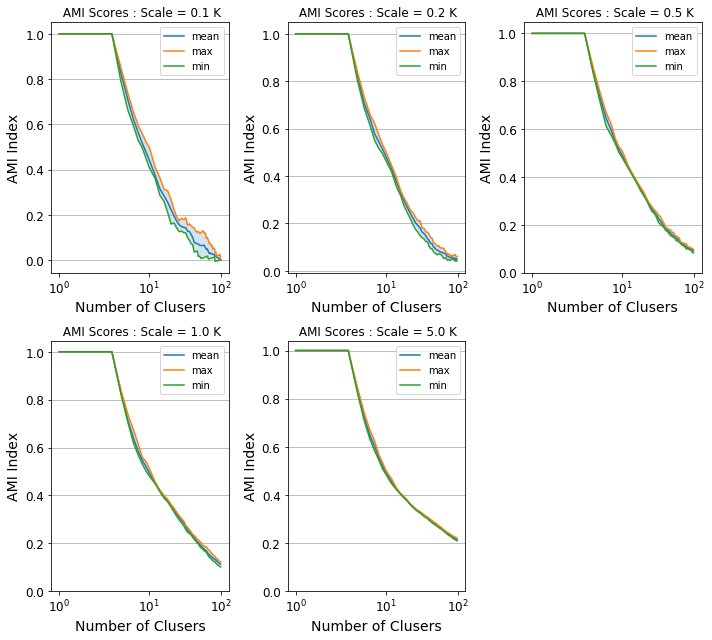

In [76]:
fig = plt.figure(figsize=(10,9))

for idx, (_mean_amis, _max_amis, _min_amis) in enumerate(
                                                zip(mean_amis_scores, max_amis_scores, min_amis_scores)):
    ax = plt.subplot(2,3,idx+1)
    plt.plot(cluster_list, _mean_amis, label='mean')
    plt.plot(cluster_list, _max_amis, label='max')
    plt.plot(cluster_list, _min_amis, label='min')
    plt.fill_between(cluster_list, _max_amis, _min_amis, alpha=0.2)
    
    #labels
    plt.xlabel("Number of Clusers", fontsize=14)
    plt.ylabel("AMI Index", fontsize=14)
    plt.title(" AMI Scores : Scale = %0.1f K" % round(scale_list[idx]/1000, 1) )
    plt.yticks(np.linspace(0,1,6), fontsize=12)
    plt.xticks( [i for i in range(len(cluster_list))], 
            [ str(i) for i in cluster_list], fontsize=12)
    plt.xscale('symlog')
    plt.gca().yaxis.grid(True, which='major') 
    plt.legend(loc='upper right')
    
fig.tight_layout()
plt.show()

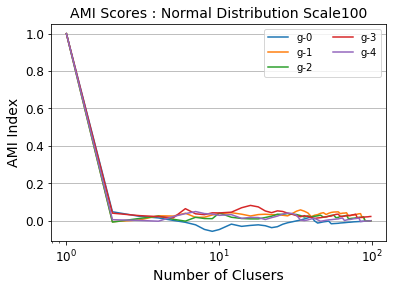

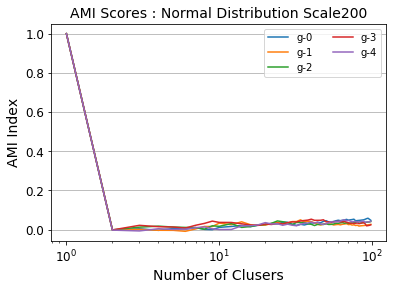

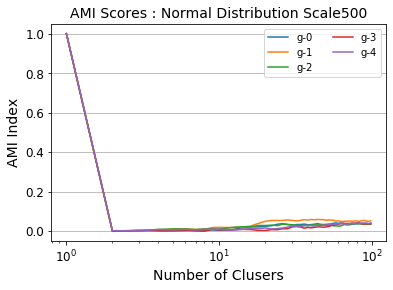

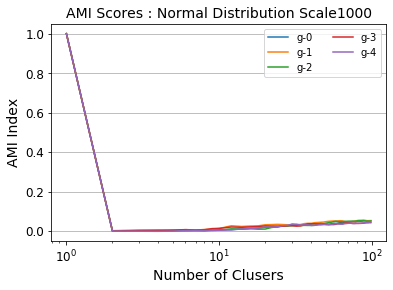

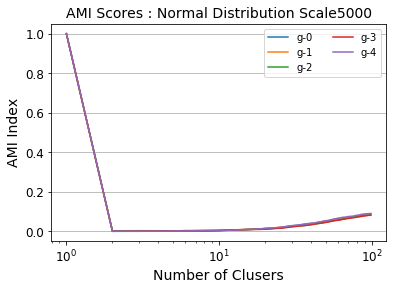

In [77]:
for idx, iscale in enumerate(scale_list):
    tmp_ami_scores = ami_scores[idx]
    fig = plt.figure()
    for igroup in range(ngroup):    
        plt.plot([i for i in cluster_list], 
                 tmp_ami_scores[igroup],
                 label='g-'+str(igroup)
                )

    plt.yticks(np.linspace(0,1,6), fontsize=12)
    #plt.xticks( [i for i in range(1,len(cluster_list),1)], 
    #            [ str(i) for i in cluster_list], fontsize=12)
    plt.xticks(fontsize=12)
    plt.xscale('log')
    plt.gca().yaxis.grid(True, which='major') 

    plt.title("AMI Scores : Normal Distribution Scale{}".format(iscale), fontsize=14)
    plt.xlabel("Number of Clusers", fontsize=14)
    plt.ylabel("AMI Index", fontsize=14)
    plt.legend(ncol=2, loc='upper right')
    plt.show()
    plt.close()

### 2. Uniform Distribution

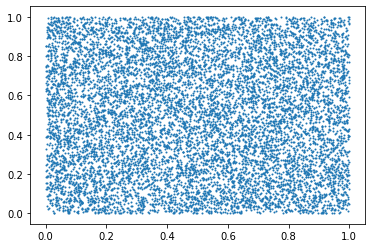

In [8]:
x = np.random.rand(10000)
y = np.random.rand(10000)
plt.scatter(x,y, s=1)

In [51]:
#Multidimensional data
X = np.random.uniform(low=0,high=1,size=(128, 10000))
X.shape

(128, 10000)

In [10]:
### Cluster
cluster_list = [i for i in range(1,10,1)] + [ i for i in range(10,100,2)]


### AMI exp
ngroup = 5

# set array
true_labels = []
ami_scores = np.zeros((len(scale_list),ngroup,len(cluster_list)))
# psuedo grand truth
true_labels = [
    #compute_aggl(gen_data(x,y), i) for i in cluster_list
    compute_aggl(gen_multi_data(X), i) for i in cluster_list
]
# plot truth cluters
'''for idx, icluster in enumerate(cluster_list):
    if icluster in mapping_list:
        save_clusterfig(gen_data(x,y),
                        true_labels[idx],
                        figdir=figdir, 
                        n_cluster=icluster, 
                        dist_type='uniform',
                        data_type='truth')'''


print(" Set Truth Labels")


# validaton data
for igroup in range(ngroup):
    print()
    print(" Entering Group %d " % igroup)
    for idx, iscale in enumerate(scale_list):
        #test_data, locs = gen_rdata(x,y,iscale)
        test_data, locs = gen_multi_rdata(X,iscale)
        for jdx, icluster in enumerate(cluster_list):
            labels = true_labels[jdx]
            test_labels = compute_aggl(test_data, icluster)
            ami_scores[idx, igroup, jdx] = AMI(labels[locs], test_labels)
            
            # save fig
    #if icluster in mapping_list:
    #            save_clusterfig(gen_data(x,y),
    #                            test_labels,
    #                            iscale, 
    #                            igroup,
    #                            test_data,
    #                            figdir=figdir, 
    #                            n_cluster=icluster, 
    #                            dist_type="uniform",
    #                            data_type="holdout"
    #                            )
        print("Normal End | Scale == %d " % iscale)
        gc.collect()

n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(1000

n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n featur

n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
Normal End | Scale == 500 
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n sampl

n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n 

n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
Normal End | Scale == 200 
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n feature

n samples x n features
(100, 128)
Normal End | Scale == 100 
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n feature

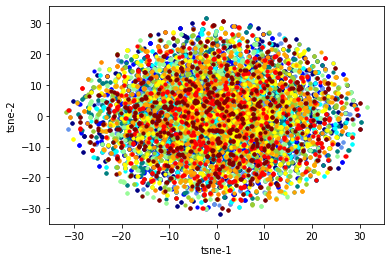

In [21]:
#TSNE
patches_ = gen_multi_data(X)
labels = true_labels[10]
colors =['navy','cornflowerblue','blue','teal',
         'aqua','palegreen', 'yellowgreen', 'darkorange',
         'yellow','orange','red','maroon'] #get_rand_colors(20)
features_2d = compute_parallel_tsne(patches_, ndim=2, nproc=4, nperplex=15)
#plot_tsne_individual(features_2d, labels, colors, n_cluster=12, scale=20, group=0, ncol=4 )

fig = plt.figure()
for i in range(12):
    idx = np.where(labels == i)
    plt.scatter(features_2d[idx,0], features_2d[idx,1], s=10, color=colors[i])
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')
plt.show()
#plt.savefig('tsne/12c_fig/all_clusters_15perplex_colors.png')
plt.close()

In [24]:
### mean
mean_amis_scores = np.mean(ami_scores, axis=1)
print(mean_amis_scores.shape)

### max
max_amis_scores = np.amax(ami_scores, axis=1)

### min
min_amis_scores = np.amin(ami_scores, axis=1)

(5, 54)


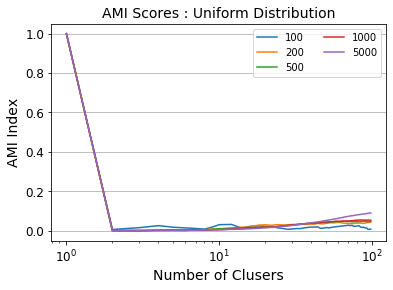

In [25]:
fig = plt.figure()
for idx, iscale in enumerate(scale_list):
    plt.plot([i for i in cluster_list], 
            mean_amis_scores[idx],
             label=str(iscale)
            )

plt.yticks(np.linspace(0,1,6), fontsize=12)
#plt.xticks( [i for i in range(1,len(cluster_list),1)], 
#            [ str(i) for i in cluster_list], fontsize=12)
plt.xticks(fontsize=12)
plt.xscale('log')
plt.gca().yaxis.grid(True, which='major') 

plt.title("AMI Scores : Uniform Distribution", fontsize=14)
plt.xlabel("Number of Clusers", fontsize=14)
plt.ylabel("AMI Index", fontsize=14)
plt.legend(ncol=2, loc='upper right')
plt.show()

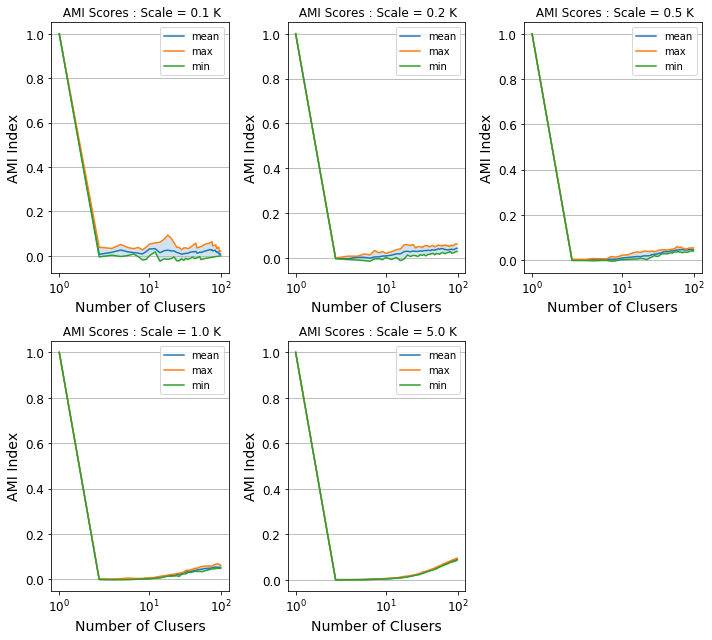

In [26]:
fig = plt.figure(figsize=(10,9))

for idx, (_mean_amis, _max_amis, _min_amis) in enumerate(
                                                zip(mean_amis_scores, max_amis_scores, min_amis_scores)):
    ax = plt.subplot(2,3,idx+1)
    plt.plot(cluster_list, _mean_amis, label='mean')
    plt.plot(cluster_list, _max_amis, label='max')
    plt.plot(cluster_list, _min_amis, label='min')
    plt.fill_between(cluster_list, _max_amis, _min_amis, alpha=0.2)
    
    #labels
    plt.xlabel("Number of Clusers", fontsize=14)
    plt.ylabel("AMI Index", fontsize=14)
    plt.title(" AMI Scores : Scale = %0.1f K" % round(scale_list[idx]/1000, 1) )
    plt.yticks(np.linspace(0,1,6), fontsize=12)
    plt.xticks( [i for i in range(len(cluster_list))], 
            [ str(i) for i in cluster_list], fontsize=12)
    plt.xscale('symlog')
    plt.gca().yaxis.grid(True, which='major') 
    plt.legend(loc='upper right')
    
fig.tight_layout()
plt.show()

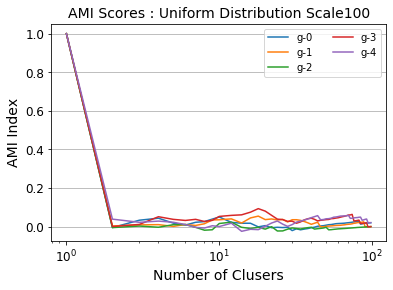

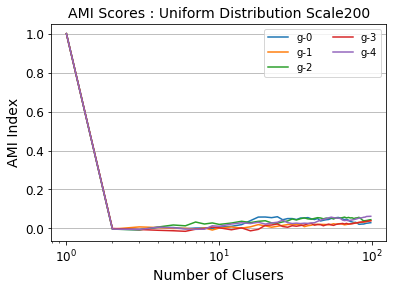

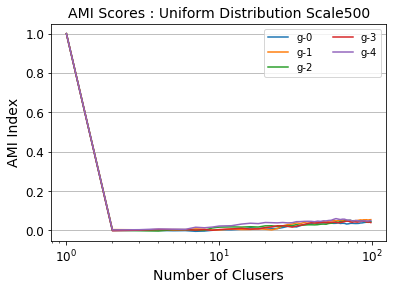

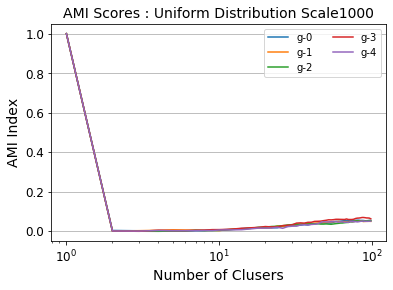

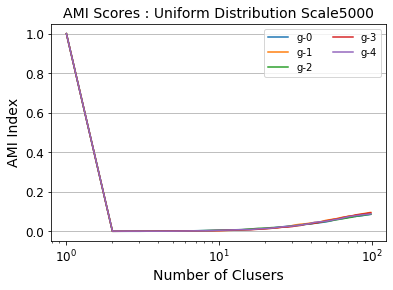

In [27]:
for idx, iscale in enumerate(scale_list):
    tmp_ami_scores = ami_scores[idx]
    fig = plt.figure()
    for igroup in range(ngroup):    
        plt.plot([i for i in cluster_list], 
                 tmp_ami_scores[igroup],
                 label='g-'+str(igroup)
                )

    plt.yticks(np.linspace(0,1,6), fontsize=12)
    #plt.xticks( [i for i in range(1,len(cluster_list),1)], 
    #            [ str(i) for i in cluster_list], fontsize=12)
    plt.xticks(fontsize=12)
    plt.xscale('log')
    plt.gca().yaxis.grid(True, which='major') 

    plt.title("AMI Scores : Uniform Distribution Scale{}".format(iscale), fontsize=14)
    plt.xlabel("Number of Clusers", fontsize=14)
    plt.ylabel("AMI Index", fontsize=14)
    plt.legend(ncol=2, loc='upper right')
    plt.show()
    plt.close()

### 3. Gaussian Mixture

In [11]:
from sklearn.datasets import make_blobs

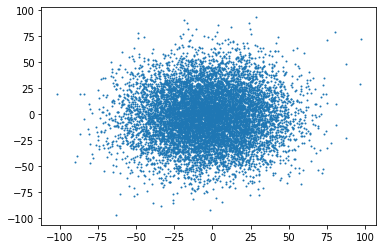

In [64]:
#2D data -- increased cluster_std to merge clusters
X, Y = make_blobs(n_samples=N, centers=3, n_features=2, random_state=100, cluster_std=25)
x, y = X[:,0], X[:,1]
plt.scatter(x,y, s=1)

In [53]:
#Multidimensional data -- increased cluster_std to merge clusters
X2, Y2 = make_blobs(n_samples=N, centers=3, n_features=128, random_state=100, cluster_std=25)
X2.shape

(10000, 128)

In [54]:
### Cluster
cluster_list = [i for i in range(1,10,1)] + [ i for i in range(10,100,2)]

### AMI exp
ngroup = 5

# set array
true_labels = []
ami_scores = np.zeros((len(scale_list),ngroup,len(cluster_list)))
# psuedo grand truth
true_labels = [
    #compute_aggl(gen_data(x,y), i) for i in cluster_list
    compute_aggl(X2, i) for i in cluster_list
]
# plot truth cluters
#for idx, icluster in enumerate(cluster_list):
#    if icluster in mapping_list:
#        save_clusterfig(gen_data(x,y),
#                        true_labels[idx],
#                        figdir=figdir, 
#                        n_cluster=icluster, 
#                        dist_type='gaussian_mixture',
#                        data_type='truth')


print(" Set Truth Labels")


# validaton data
for igroup in range(ngroup):
    print()
    print(" Entering Group %d " % igroup)
    for idx, iscale in enumerate(scale_list):
        #test_data, locs = gen_rdata(x,y,iscale)
        test_data, locs = gen_multi_rdata(X2,iscale,transp=False)
        for jdx, icluster in enumerate(cluster_list):
            labels = true_labels[jdx]
            test_labels = compute_aggl(test_data, icluster)
            ami_scores[idx, igroup, jdx] = AMI(labels[locs], test_labels)
            
            # save fig
       #     if icluster in mapping_list:
       #         save_clusterfig(gen_data(x,y),
       #                         test_labels,
       #                         iscale, 
       #                         igroup,
       #                         test_data,
       #                         figdir=figdir, 
       #                         n_cluster=icluster, 
       #                         dist_type="gaussian_mixture",
       #                         data_type="holdout"
       #                         )
        print("Normal End | Scale == %d " % iscale)
        gc.collect()

n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(10000, 128)
n samples x n features
(1000

n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n featur

n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
Normal End | Scale == 500 
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n samples x n features
(1000, 128)
n s

n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n 

n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
Normal End | Scale == 200 
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n features
(500, 128)
n samples x n feature

n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n features
(200, 128)
n samples x n 

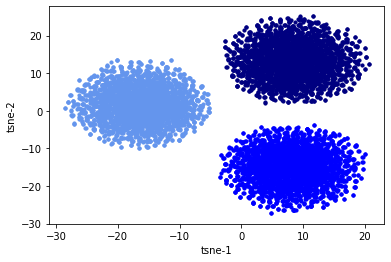

In [46]:
#TSNE- cluster_dev = 8, N_clusters = 3
patches_ = X2
labels = true_labels[2]
colors =['navy','cornflowerblue','blue','teal',
         'aqua','palegreen', 'yellowgreen', 'darkorange',
         'yellow','orange','red','maroon'] #get_rand_colors(20)
features_2d = compute_parallel_tsne(patches_, ndim=2, nproc=4, nperplex=15)
#plot_tsne_individual(features_2d, labels, colors, n_cluster=12, scale=20, group=0, ncol=4 )

fig = plt.figure()
for i in range(3):
    idx = np.where(labels == i)
    plt.scatter(features_2d[idx,0], features_2d[idx,1], s=10, color=colors[i])
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')
plt.show()
#plt.savefig('tsne/12c_fig/all_clusters_15perplex_colors.png')
plt.close()

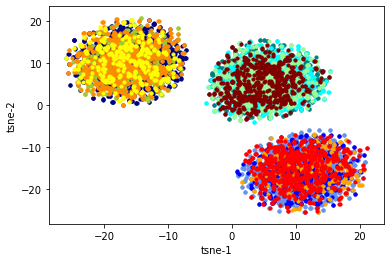

In [48]:
#TSNE- cluster_dev = 8, N_clusters = 12
patches_ = X2
labels = true_labels[10]
colors =['navy','cornflowerblue','blue','teal',
         'aqua','palegreen', 'yellowgreen', 'darkorange',
         'yellow','orange','red','maroon'] #get_rand_colors(20)
features_2d = compute_parallel_tsne(patches_, ndim=2, nproc=4, nperplex=15)
#plot_tsne_individual(features_2d, labels, colors, n_cluster=12, scale=20, group=0, ncol=4 )

fig = plt.figure()
for i in range(12):
    idx = np.where(labels == i)
    plt.scatter(features_2d[idx,0], features_2d[idx,1], s=10, color=colors[i])
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')
plt.show()
#plt.savefig('tsne/12c_fig/all_clusters_15perplex_colors.png')
plt.close()

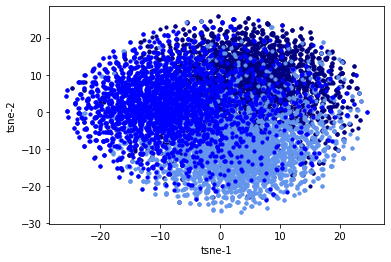

In [55]:
#TSNE- cluster_dev = 25, N_clusters = 3
patches_ = X2
labels = true_labels[2]
colors =['navy','cornflowerblue','blue','teal',
         'aqua','palegreen', 'yellowgreen', 'darkorange',
         'yellow','orange','red','maroon'] #get_rand_colors(20)
features_2d = compute_parallel_tsne(patches_, ndim=2, nproc=4, nperplex=15)
#plot_tsne_individual(features_2d, labels, colors, n_cluster=12, scale=20, group=0, ncol=4 )

fig = plt.figure()
for i in range(3):
    idx = np.where(labels == i)
    plt.scatter(features_2d[idx,0], features_2d[idx,1], s=10, color=colors[i])
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')
plt.show()
#plt.savefig('tsne/12c_fig/all_clusters_15perplex_colors.png')
plt.close()

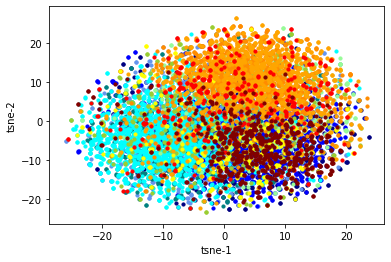

In [56]:
#TSNE- cluster_dev = 25, N_clusters = 12
from MulticoreTSNE import MulticoreTSNE as TSNE
patches_ = X2# gen_multi_data(X)
labels = true_labels[10]
colors =['navy','cornflowerblue','blue','teal',
         'aqua','palegreen', 'yellowgreen', 'darkorange',
         'yellow','orange','red','maroon'] #get_rand_colors(20)
features_2d = compute_parallel_tsne(patches_, ndim=2, nproc=4, nperplex=15)
#plot_tsne_individual(features_2d, labels, colors, n_cluster=12, scale=20, group=0, ncol=4 )

fig = plt.figure()
for i in range(12):
    idx = np.where(labels == i)
    plt.scatter(features_2d[idx,0], features_2d[idx,1], s=10, color=colors[i])
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')
plt.show()
#plt.savefig('tsne/12c_fig/all_clusters_15perplex_colors.png')
plt.close()

In [57]:
### mean
mean_amis_scores = np.mean(ami_scores, axis=1)
print(mean_amis_scores.shape)

### max
max_amis_scores = np.amax(ami_scores, axis=1)

### min
min_amis_scores = np.amin(ami_scores, axis=1)

(5, 54)


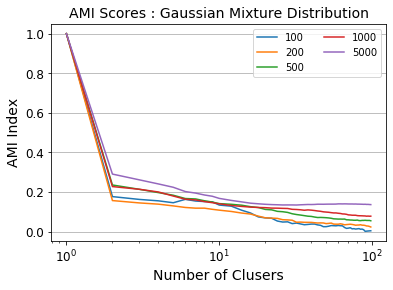

In [58]:
fig = plt.figure()
for idx, iscale in enumerate(scale_list):
    plt.plot([i for i in cluster_list], 
            mean_amis_scores[idx],
             label=str(iscale)
            )

plt.yticks(np.linspace(0,1,6), fontsize=12)
#plt.xticks( [i for i in range(1,len(cluster_list),1)], 
#            [ str(i) for i in cluster_list], fontsize=12)
plt.xticks(fontsize=12)
plt.xscale('log')
plt.gca().yaxis.grid(True, which='major') 

plt.title("AMI Scores : Gaussian Mixture Distribution", fontsize=14)
plt.xlabel("Number of Clusters", fontsize=14)
plt.ylabel("AMI Index", fontsize=14)
plt.legend(ncol=2, loc='upper right')
plt.show()

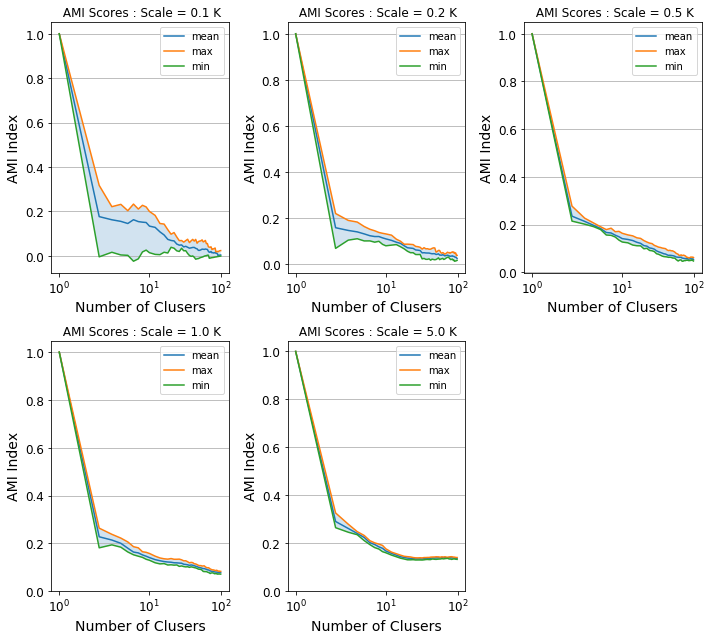

In [59]:
fig = plt.figure(figsize=(10,9))

for idx, (_mean_amis, _max_amis, _min_amis) in enumerate(
                                                zip(mean_amis_scores, max_amis_scores, min_amis_scores)):
    ax = plt.subplot(2,3,idx+1)
    plt.plot(cluster_list, _mean_amis, label='mean')
    plt.plot(cluster_list, _max_amis, label='max')
    plt.plot(cluster_list, _min_amis, label='min')
    plt.fill_between(cluster_list, _max_amis, _min_amis, alpha=0.2)
    
    #labels
    plt.xlabel("Number of Clusters", fontsize=14)
    plt.ylabel("AMI Index", fontsize=14)
    plt.title(" AMI Scores : Scale = %0.1f K" % round(scale_list[idx]/1000, 1) )
    plt.yticks(np.linspace(0,1,6), fontsize=12)
    plt.xticks( [i for i in range(len(cluster_list))], 
            [ str(i) for i in cluster_list], fontsize=12)
    plt.xscale('symlog')
    plt.gca().yaxis.grid(True, which='major') 
    plt.legend(loc='upper right')
    
fig.tight_layout()
plt.show()

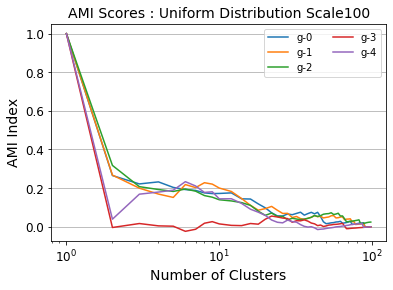

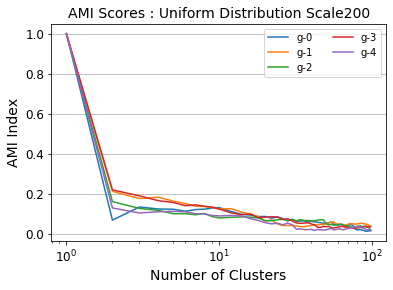

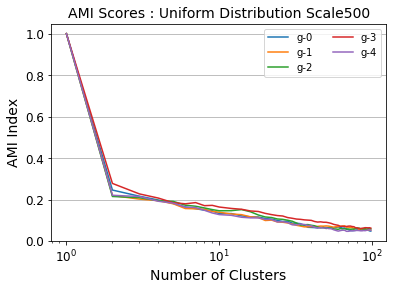

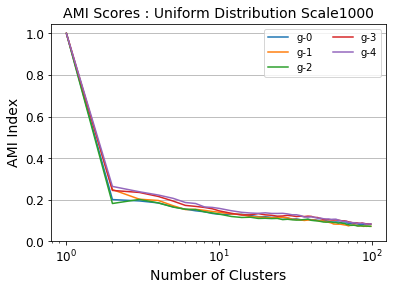

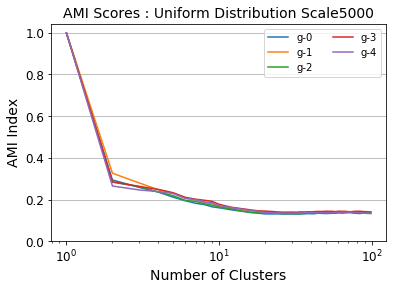

In [62]:
for idx, iscale in enumerate(scale_list):
    tmp_ami_scores = ami_scores[idx]
    fig = plt.figure()
    for igroup in range(ngroup):    
        plt.plot([i for i in cluster_list], 
                 tmp_ami_scores[igroup],
                 label='g-'+str(igroup)
                )

    plt.yticks(np.linspace(0,1,6), fontsize=12)
    #plt.xticks( [i for i in range(1,len(cluster_list),1)], 
    #            [ str(i) for i in cluster_list], fontsize=12)
    plt.xticks(fontsize=12)
    plt.xscale('log')
    plt.gca().yaxis.grid(True, which='major') 

    plt.title("AMI Scores : Uniform Distribution Scale{}".format(iscale), fontsize=14)
    plt.xlabel("Number of Clusters", fontsize=14)
    plt.ylabel("AMI Index", fontsize=14)
    plt.legend(ncol=2, loc='upper right')
    plt.show()
    plt.close()